<a href="https://colab.research.google.com/github/archikumari0770/sentiment_analysis2/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

# Download NLTK data
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Example text
text = "I love this product! It's amazing and works perfectly."

# Get sentiment scores
sentiment = sia.polarity_scores(text)

print(sentiment)

{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'compound': 0.9259}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
!pip install transformers

from transformers import pipeline

# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Analyze sentiment
result = sentiment_pipeline("I hate when my phone battery dies quickly")[0]
print(f"Label: {result['label']}, with score: {round(result['score'], 4)}")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


Label: NEGATIVE, with score: 0.9996


In [ ]:
# Load a sample dataset
!pip install datasets
from datasets import load_dataset
from tqdm import tqdm # Import tqdm here

# Load the IMDb reviews dataset
dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]

# Let's look at one example
print(train_data[0])

# Function to get sentiment
def get_sentiment(text):
    # Truncate text to the maximum length the model can handle (usually 512 for this model)
    max_len = 512
    truncated_text = text[:max_len]
    result = sentiment_pipeline(truncated_text)[0]
    return result['label'], result['score']

# Apply to a sample of the dataset
sample_size = 100
results = []
for i in tqdm(range(sample_size)):
    text = train_data[i]['text']
    label = train_data[i]['label']
    pred_label, pred_score = get_sentiment(text)
    results.append({
        'text': text[:100] + "...",  # Show first 100 chars
        'true_label': 'positive' if label == 1 else 'negative',
        'pred_label': pred_label,
        'pred_score': pred_score
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df.head())

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

100%|██████████| 100/100 [00:00<00:00, 142.30it/s]


                                                text true_label pred_label  \
0  I rented I AM CURIOUS-YELLOW from my video sto...   negative   NEGATIVE   
1  "I Am Curious: Yellow" is a risible and preten...   negative   NEGATIVE   
2  If only to avoid making this type of film in t...   negative   NEGATIVE   
3  This film was probably inspired by Godard's Ma...   negative   NEGATIVE   
4  Oh, brother...after hearing about this ridicul...   negative   NEGATIVE   

   pred_score  
0    0.991342  
1    0.999483  
2    0.998259  
3    0.762378  
4    0.947114  


In [ ]:
!pip install fsspec==2023.9.0  # Downgrade to a stable version


Accuracy: 0.87


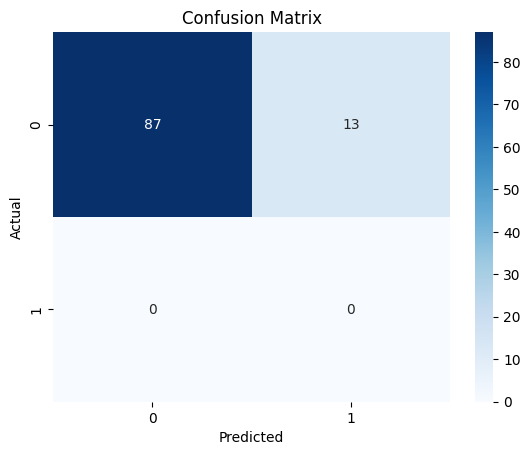

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Convert labels to numerical (0=negative, 1=positive)
results_df['true_num'] = results_df['true_label'].apply(lambda x: 1 if x == 'positive' else 0)
results_df['pred_num'] = results_df['pred_label'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

# Compute accuracy
accuracy = accuracy_score(results_df['true_num'], results_df['pred_num'])
print(f"Accuracy: {accuracy:.2f}")

# Plot confusion matrix
cm = confusion_matrix(results_df['true_num'], results_df['pred_num'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

# Load tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

small_train_dataset = train_data.select(range(1000)).map(tokenize_function, batched=True)
small_test_dataset = test_data.select(range(1000)).map(tokenize_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",  # Disable Weights & Biases logging
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
)

# Train the model
trainer.train()

# Evaluate
eval_result = trainer.evaluate()
print(f"Evaluation results: {eval_result}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.002679
2,No log,0.001221
3,No log,0.000998


Evaluation results: {'eval_loss': 0.0009983477648347616, 'eval_runtime': 17.4548, 'eval_samples_per_second': 57.291, 'eval_steps_per_second': 3.609, 'epoch': 3.0}


In [ ]:
test_sentences = [
    "I love this product! It's amazing!",  # Positive
    "This is the worst experience ever.",  # Negative
    "The weather is okay today.",           # Neutral
]

for sentence in test_sentences:
    result = sentiment_pipeline(sentence)[0]
    print(f"Text: {sentence}")
    print(f"Predicted: {result['label']} (Score: {result['score']:.2f})\n")

Text: I love this product! It's amazing!
Predicted: POSITIVE (Score: 1.00)

Text: This is the worst experience ever.
Predicted: NEGATIVE (Score: 1.00)

Text: The weather is okay today.
Predicted: POSITIVE (Score: 1.00)



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Example: Test on 100 samples
true_labels = []
pred_labels = []

for i in range(100):
    text = test_data[i]["text"]
    true_label = test_data[i]["label"]  # 0=negative, 1=positive

    # Truncate text to the model's maximum sequence length
    max_len = 512
    truncated_text = text[:max_len]

    pred_label = sentiment_pipeline(truncated_text)[0]["label"]

    true_labels.append(true_label)
    pred_labels.append(1 if pred_label == "POSITIVE" else 0)

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.2f}")

# Detailed report
print(classification_report(true_labels, pred_labels, target_names=["Negative", "Positive"]))

Accuracy: 0.85
              precision    recall  f1-score   support

    Negative       1.00      0.85      0.92       100
    Positive       0.00      0.00      0.00         0

    accuracy                           0.85       100
   macro avg       0.50      0.42      0.46       100
weighted avg       1.00      0.85      0.92       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
edge_cases = [
    "The movie was not bad.",               # Negation → Positive
    "Meh, it was okay I guess.",           # Weak sentiment
    "I hate this, but the design is good." # Mixed sentiment
]

for text in edge_cases:
    result = sentiment_pipeline(text)[0]
    print(f"Text: {text}")
    print(f"Predicted: {result['label']} (Score: {result['score']:.2f})\n")

Text: The movie was not bad.
Predicted: POSITIVE (Score: 1.00)

Text: Meh, it was okay I guess.
Predicted: POSITIVE (Score: 1.00)

Text: I hate this, but the design is good.
Predicted: POSITIVE (Score: 1.00)

